# Traitement des données des simulations

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pickle
import scipy
from scipy import signal
import sympy as sy
from IPython.display import display
from scipy.io.wavfile import write as wavWrite
import h5py
import ast
import os
import sys
import shutil
sy.init_printing()
#import tikzplotlib

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# Settings pour les figures matplotlib
mpl.rcParams['figure.dpi'] = 72

#%matplotlib nbagg

FIGSIZE  = (10,5)
FONTSIZE = 30
TICK_FONTSIZE = 24
LEGEND_FONTSIZE = 22

font = {'family' : 'serif',
        'weight' : 'bold',
        'size'   : 18}

plt.rc('font', **font)
plt.rc('text', usetex=True)
LATEX_FIG_PATH = "../01_FIGS/"
FIGS_PATH      = "02_figs/"
PPTY_XVBAR = {'c':  'r', 
              'linestyle':'-.', 
              'linewidth':0.75,
             }
PPTY_LEG = { 'fontsize' : 16,
             'loc'      : 'upper left',
           }

In [3]:
fmt = lambda s: r'%s_{%s}' % (s.split('_', 1)[0], s.split('_', 1)[1].replace('_', ''))

def export2tikzpdf(path, name):
    """ Exporte la figure courante dans un nouveau dossier,
    en y ajoutant un numéro unique, ordre croissant
    @args: path: chemin vers le dossier d'export
    @args: name: nom du dossier 
    """
    # Liste des dossier dans le path    
    list_dir = []
    for (dirpath, dirnames, filenames) in os.walk(path):
        list_dir.extend(dirnames)
        break
        
        
    # Dans le cas où la liste de dossier est vide
    if not list_dir:
        list_dir.append(str(0))
    
    # Nombre le plus grand?
    for i in range(len(list_dir)):
        list_dir[i] = int(list_dir[i][0:2])
        
    # rajoute un zéro au debut si < 10 (formattage)
    new_fig_number = str(max(list_dir) + 1).zfill(2)

    full_path_new_dir = os.path.join(path, 
                                     str(new_fig_number) + '_' + name)
    
    # Création du nouveau dossier
    os.mkdir(full_path_new_dir)
    
    # Copie des fichiers de makefile + conteneur latex
    src_files = ['fig_main.tex', 'makefile']
    dst_files = ['','']
    for i in range(len(src_files)):
        dst_files[i] = os.path.join(full_path_new_dir, src_files[i])
        src_files[i] = os.path.join(path, src_files[i])
        shutil.copyfile(src_files[i], dst_files[i])

    # generation du fichier tikz
    tikz_file_path = os.path.join(full_path_new_dir,"fig.tex")
    tikzplotlib.save(tikz_file_path)
    
def next_power_of_2(x):  
    return 1 if x == 0 else 2**(x - 1).bit_length()

### Chargement des données

In [4]:
#%% Loading dataset
%store -r filename 
#filename = '03_data/simu.04_03.09_35.h5'
print(filename)

fid = h5py.File(filename, 'r')
fid.flush()

metadata = fid["metadata"]
data     = fid["data_simu"]
model    = fid["model"]

date_now = metadata["date_now"][:]
config = ast.literal_eval(str(metadata["config"][0]))
print(*date_now)

03_data/simu.05_14.15_17.h5
5 14 15 17


In [5]:
SAVE_FIG = False
if SAVE_FIG:
    FOLDER_PATH = FIGS_PATH + "simu_{0}_{1}.{2}_{3}".format(*(str(val).zfill(2) for val in date_now))
    os.mkdir(FOLDER_PATH)

In [6]:
t = data["t"][:]
tmax = 0.002

indt = (t <= tmax) * (t >= 0.0009)

N_ports, Nx, NW = model["Nu"][0], model["Nx"][0], model["Nw"][0]

In [7]:
#xbar = [t[300],]
#xbar = [0.1, 0.2]
xbar = [0.001]

In [8]:
config

{'fs': 1000000.0,
 'path': '/home/victorw/ownCloud/IRCAM/03_DOCS/30_code_cpp_vocal_tract/vocalTractCpp/python/03_data',
 'lang': 'c++',
 'cmake': 'cmake',
 'grad': 'discret',
 'maxit': 20,
 'pbar': False,
 'split': False,
 'timer': True,
 'epsdg': 1.4901161193847656e-08,
 'eps': 2.220446049250313e-16}

In [9]:
volume_refs = [model["VT_subs"]["V_0_1"][()], model["VT_subs"]["V_0_2"][()]]
rho_refs    = [model["VT_subs"]["rho_0"][()], model["VT_subs"]["rho_0"][()]]

In [10]:
# On récupère les VT_subs
params_label = list(model["VT_subs"].keys())
ell_1 = model["VT_subs"]["ell_1"][()]

for label in params_label:
    value = model["VT_subs"][label][()]
    exec("%s = %f" % (label, value))
    print("%s = %f" % (label, value))

L_1 = 0.020000
L_2 = 0.020000
L_3 = 0.020000
L_4 = 0.020000
L_5 = 0.020000
L_6 = 0.020000
L_7 = 0.020000
P_0 = 101325.000000
V_0_1 = 0.000010
V_0_2 = 0.000010
V_0_3 = 0.000010
V_0_4 = 0.000010
V_0_5 = 0.000010
V_0_6 = 0.000010
V_0_7 = 0.000010
Z_ray = 2222.222222
ell_1 = 0.012500
ell_2 = 0.012500
ell_3 = 0.012500
ell_4 = 0.012500
ell_5 = 0.012500
ell_6 = 0.012500
ell_7 = 0.012500
gamma = 1.400000
rho_0 = 1.225000


--------------
## Entrées

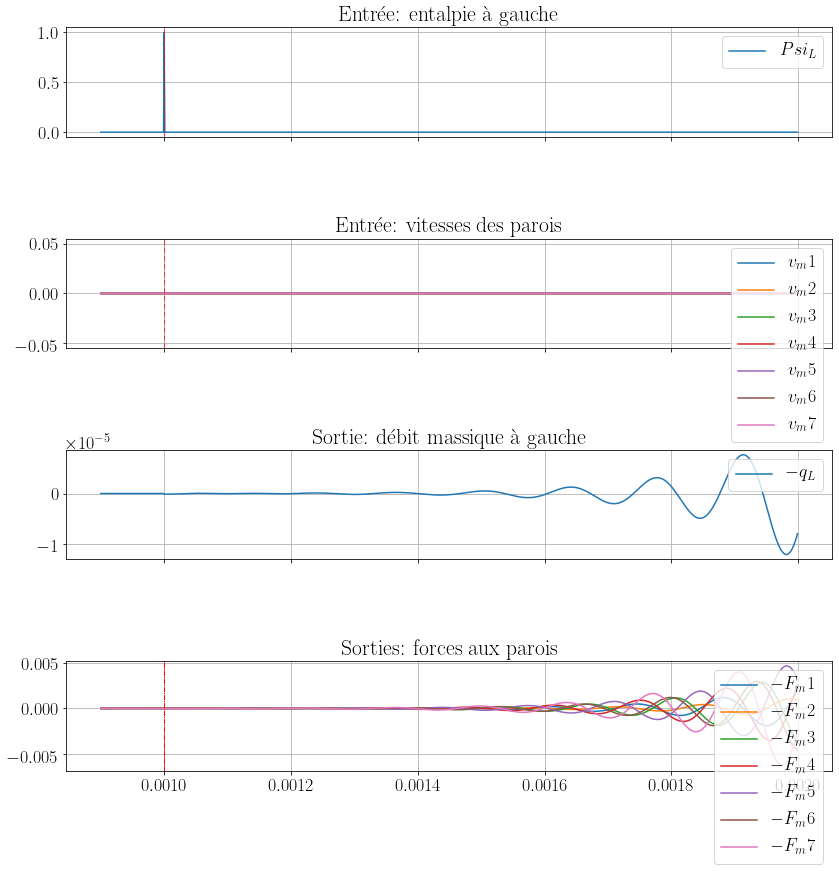

In [11]:
#%matplotlib nbagg
fig, axs = plt.subplots(4, 1, figsize=(12, 12), sharex=True)

## Entrées
ax = axs[0]
label = r'$%s$' % (model["u_label"][0])
ax.plot(t[indt], data["u"][indt,0], label=label)
ax.set_title('Entrée: entalpie à gauche')
for bar in xbar:
    ax.axvline(x=bar, **PPTY_XVBAR)

# Vitesses
ax = axs[1]
for i in range(1,N_ports):
    label = r'$%s$' % (model["u_label"][i])
    ax.plot(t[indt], data["u"][indt,i], label=label)
ax.set_title('Entrée: vitesses des parois')

for bar in xbar:
    ax.axvline(x=bar, **PPTY_XVBAR)

## Sorties: Forces

ax = axs[2]
label = r'$%s$' % (model["y_label"][0])
ax.plot(t[indt], data["y"][indt,0], label=label)
ax.set_title('Sortie: débit massique à gauche')

ax = axs[3]
for i in range(1, N_ports):
    label = r'$%s$' % (model["y_label"][i])
    ax.plot(t[indt], data["y"][indt,i], label=label)
ax.set_title('Sorties: forces aux parois')

for bar in xbar:
    ax.axvline(x=bar, **PPTY_XVBAR)


for bar in xbar:
    ax.axvline(x=bar, **PPTY_XVBAR)

for ax in axs.ravel():
    ax.legend(frameon=True, loc="upper right")
    ax.grid()

plt.tight_layout()
for bar in xbar:
    ax.axvline(x=bar, **PPTY_XVBAR)
    
if SAVE_FIG:
    title = "input_output"
    tmp_path = os.path.join(FOLDER_PATH,title)
    plt.savefig(tmp_path + '.png', format='png', dpi=300)
    plt.savefig(tmp_path + '.pdf', format='pdf')

----------
## Bilan de puissance et ports

In [12]:
# Calcule du bilan de puissance
N_diss = len(model["w_label"][:])
Pdiss = np.prod([data["w"][:,0],data["z"][:,0]], axis=0)
for i in range(1, N_diss):
    prod = np.prod([data["w"][:,i],data["z"][:,i]], axis=0)
    Pdiss = np.add(Pdiss, prod)

Pext = np.prod([data["u"][:,0],data["y"][:,0]], axis=0)
for i in range(1, N_ports):
    prod = np.prod([data["u"][:,i],data["y"][:,i]], axis=0)
    Pext = np.add(Pext, prod)

dEdt = np.prod([data["dxH"][:,0],data["dtx"][:,0]], axis=0)
for i in range(1,Nx):
    prod = np.prod([data["dxH"][:,i],data["dtx"][:,i]], axis=0)
    dEdt = np.add(dEdt, prod)

/home/victorw/.virtualenvs/pyphs/lib/python3.8/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/victorw/.virtualenvs/pyphs/lib/python3.8/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


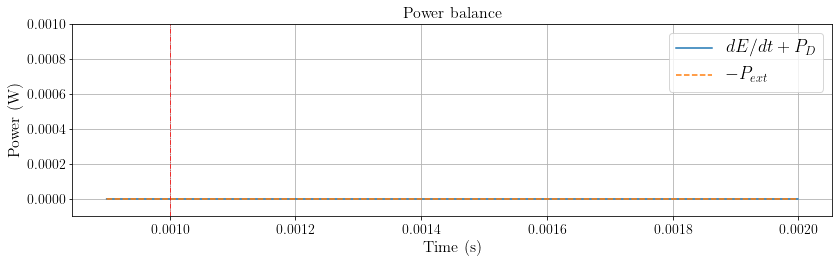

In [13]:
fig = plt.figure(figsize=(12, 4))
ax = plt.gca()

# ---- Power balance --- #
ax.plot(t[indt], (Pdiss + dEdt)[indt])
ax.plot(t[indt], (-Pext)[indt], '--')
ax.set_title(r'Power balance', fontsize=16)
ax.grid()

ax.legend([r'$dE/dt + P_D$', '$-P_{ext}$'], loc="upper right")
ax.set_ylabel('Power (W)', fontsize=16)
ax.set_xlabel('Time (s)', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=10)
plt.ylim([-1e-4, 1e-3])

for bar in xbar:
    ax.axvline(x=bar, **PPTY_XVBAR)
plt.tight_layout()



if SAVE_FIG:
    title = "power_balance"
    tmp_path = os.path.join(FOLDER_PATH,title)
    plt.savefig(tmp_path + '.png', format='png', dpi=300)
    plt.savefig(tmp_path + '.pdf', format='pdf')

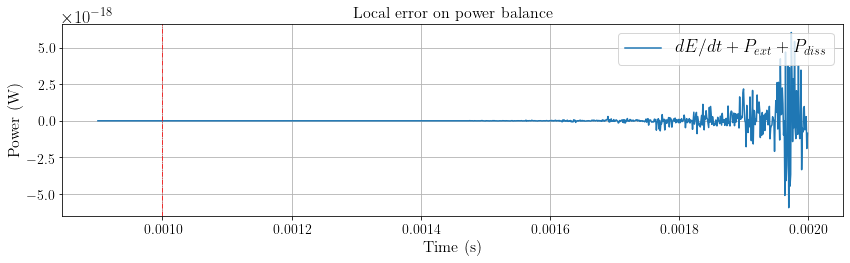

In [14]:
fig = plt.figure(figsize=(12, 4))
ax = plt.gca()

# ---- Power balance --- #
ax.plot(t[indt], (dEdt+Pext+Pdiss)[indt])
#ax.semilogy(t[indt], (dEdt+Pext+Pdiss)[indt])
ax.set_title(r'Local error on power balance', fontsize=16)
ax.grid()

ax.legend([r'$dE/dt+P_{ext}+P_{diss}$'], loc="upper right")
ax.set_ylabel('Power (W)', fontsize=16)
ax.set_xlabel('Time (s)', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=10)

#ax.set_ylim([1e-50,1e-9])

for bar in xbar:
    ax.axvline(x=bar, **PPTY_XVBAR)
plt.tight_layout()

if SAVE_FIG:
    title = "error_on_power_balance"
    tmp_path = os.path.join(FOLDER_PATH,title)
    plt.savefig(tmp_path + '.png', format='png', dpi=300)
    plt.savefig(tmp_path + '.pdf', format='pdf')

## États

In [15]:
if False:
    fmt = lambda s: r'$%s_{%s}$' % (s.split('_', 1)[0], s.split('_', 1)[1].replace('_', ''))
    fig, axs = plt.subplots(Nx, 1, sharex=True, figsize=(12,16*4))
    marker = '-'
    tmin = 0.1
    tmax = 0.101
    for i in range(Nx):
        label = fmt(str(model["x_label"][i]))
        label = r'$%s$' % label.replace('$', '')
        plt.sca(axs[i])
        plt.plot(t, data["x"][:,i], marker)
        # Cosmétique
        plt.legend([label], loc='upper left')
        plt.grid()
        plt.xlim([tmin, tmax])
        if not i:
            plt.title('x', fontsize=24)
        #barres verticales
        for bar in xbar:
            plt.axvline(x=bar, **PPTY_XVBAR)

    plt.tight_layout()

## Gradient

In [16]:
if False:
    fmt = lambda s: r'$%s_{%s}$' % (s.split('_', 1)[0], s.split('_', 1)[1].replace('_', ''))
    fig, axs = plt.subplots(Nx, 1, sharex=True, figsize=(12,16*4))
    marker = '-'
    tmin = 0.1
    tmax = 0.101
    for i in range(Nx):
        label = fmt(str(model["x_label"][i]))
        label = r'dxH $%s$' % label.replace('$', '')
        plt.sca(axs[i])
        plt.plot(t, data["dxH"][:,i], marker)
        # Cosmétique
        plt.legend([label], loc='upper left')
        plt.grid()
        plt.xlim([tmin, tmax])
        if not i:
            plt.title('dxH', fontsize=24)
        #barres verticales
        for bar in xbar:
            plt.axvline(x=bar, **PPTY_XVBAR)

    plt.tight_layout()

--------------
## Observateurs

In [17]:
print(model["y_label"][:])
print(model["w_label"][:])

['-q_L' '-F_m1' '-F_m2' '-F_m3' '-F_m4' '-F_m5' '-F_m6' '-F_m7']
['v_k1' 'v_k2' 'v_k3' 'v_k4' 'v_k5' 'v_k6' 'v_k7' 'q']


In [18]:
rho_refs[0]

In [19]:
xlabel = model["x_label"][:]
for val,i in enumerate(xlabel):
    print("{} : {}".format(val, i))

0 : nu_L1
1 : nu_12
2 : nu_23
3 : nu_34
4 : nu_45
5 : nu_56
6 : nu_67
7 : nu_R7
8 : Pi_y1
9 : Pi_y2
10 : Pi_y3
11 : Pi_y4
12 : Pi_y5
13 : Pi_y6
14 : Pi_y7
15 : V_1
16 : V_2
17 : V_3
18 : V_4
19 : V_5
20 : V_6
21 : V_7
22 : rho_1
23 : rho_2
24 : rho_3
25 : rho_4
26 : rho_5
27 : rho_6
28 : rho_7
29 : x_k1
30 : x_k2
31 : x_k3
32 : x_k4
33 : x_k5
34 : x_k6
35 : x_k7


## Représentation fréquentielle

In [20]:
xlabel = model["x_label"][:]
for val,i in enumerate(model["w_label"]):
    print("{} : {}".format(val, i))

0 : v_k1
1 : v_k2
2 : v_k3
3 : v_k4
4 : v_k5
5 : v_k6
6 : v_k7
7 : q


<IPython.core.display.Javascript object>


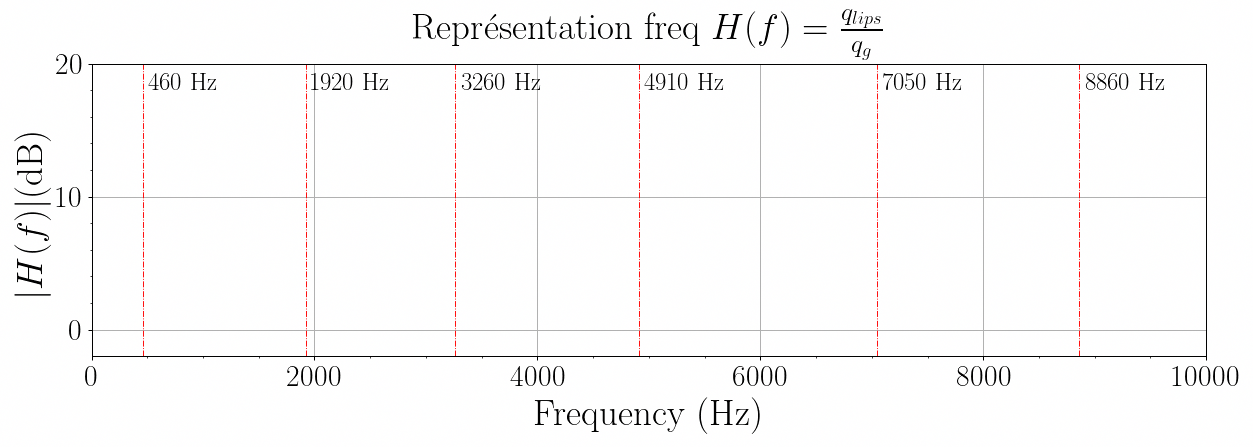

In [21]:
%matplotlib nbagg
q_glotte  = data['dxH'][:,0]
q_levres  = data['w'][:,-1]

len_sig   = len(q_glotte)
fs        = config["fs"]

freq_max  = fs/2
Nfft      = int(next_power_of_2(len_sig))
freq_vec  = np.linspace(-fs/2, fs/2, Nfft) 
indf      = (freq_vec > 0) * (freq_vec < freq_max)
win       = scipy.signal.get_window('hann', len_sig)
#win       = signal.kaiser(len_sig, beta=14)

fft_qout = np.fft.fft(q_levres*win, Nfft)
fft_qin  = np.fft.fft(q_glotte*win, Nfft)
fft_H_shift = np.fft.fftshift(np.divide(fft_qout, fft_qin))
fft_shift_qout = np.fft.fftshift(fft_qout)

############
## FIGURE ##
fig = plt.figure(figsize=(14,5))
ax = plt.gca()

plt.plot(freq_vec[indf], 10*np.log10(np.abs(fft_H_shift[indf])), linewidth=3)
#plt.plot(freq_vec[indf], 10*np.log10(np.abs(np.fft.fftshift((fft_qout[indf])))), linewidth=3)
#plt.plot(freq_vec[indf], 10*np.log10(np.abs((fft_shift_qout[indf]))), linewidth=3)
plt.xlabel('Frequency (Hz)', fontsize=FONTSIZE)
plt.ylabel('$|H(f)|$(dB)', fontsize=FONTSIZE)

plt.ylim([-2, 20])
plt.xlim([0, 10000])
plt.title(r'Représentation freq $H(f)=\frac{q_{lips}}{q_{g}}$', fontsize=FONTSIZE)
plt.grid()

freq_bar = [460, 1920, 3260, 4910, 7050, 8860]
for bar in freq_bar:
    ax.axvline(x=bar, **PPTY_XVBAR)
    plt.annotate(r"{0} Hz".format(bar), 
                       (bar+50, 18),
                       #bbox=dict(boxstyle='Round', fc='white', ec='k', pad=0.4),
                       fontsize=20)

ax.tick_params(labelsize=TICK_FONTSIZE)
ax.minorticks_on()
plt.tight_layout()

if SAVE_FIG:
    title = "fonction_transfert_uL_vers_uR"
    tmp_path = os.path.join(FOLDER_PATH,title)
    plt.savefig(tmp_path + '.pdf', format='pdf')
    print('hehe')

<IPython.core.display.Javascript object>


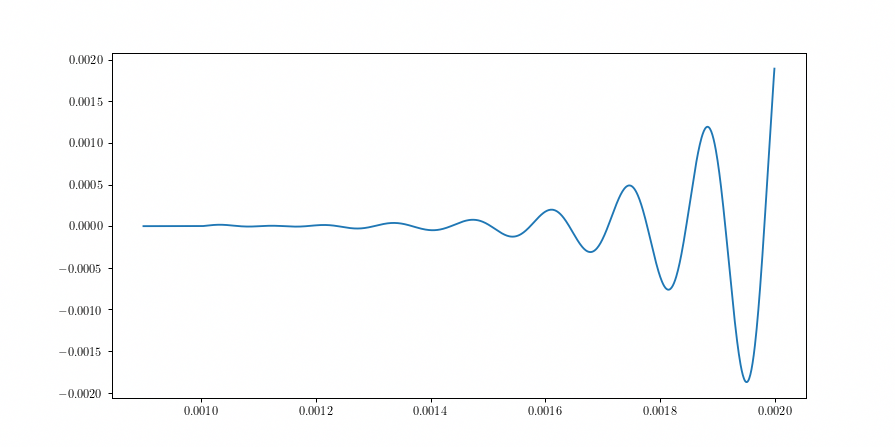

In [22]:
plt.figure(figsize=FIGSIZE)
plt.plot(t[indt], data['y'][indt,1])